In this notebook we are going to extract the average sentiment scores based on LDA-extracted topic modelling of the review data for the extra test set data.

In [1]:
#Import packages
import sys
import gensim
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from langdetect import detect, LangDetectException
import numpy as np
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect, LangDetectException
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from tqdm import tqdm
import gc
import glob
import ast
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.corpora import MmCorpus
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import download

In [3]:
# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of column content
pd.set_option('display.max_rows', None)  # Show all rows
# Read reviews from csv files
reviews_madrid=pd.read_csv('reviews_madrid.csv.gz')
reviews_singapore=pd.read_csv('reviews_singapore.csv.gz')
reviews_madrid['city']='Madrid'
reviews_singapore['city']='Singapore'

In [4]:
reviews_combined=pd.concat([reviews_madrid,reviews_singapore],axis=0)

In [5]:
reviews_combined.shape

(1267742, 7)

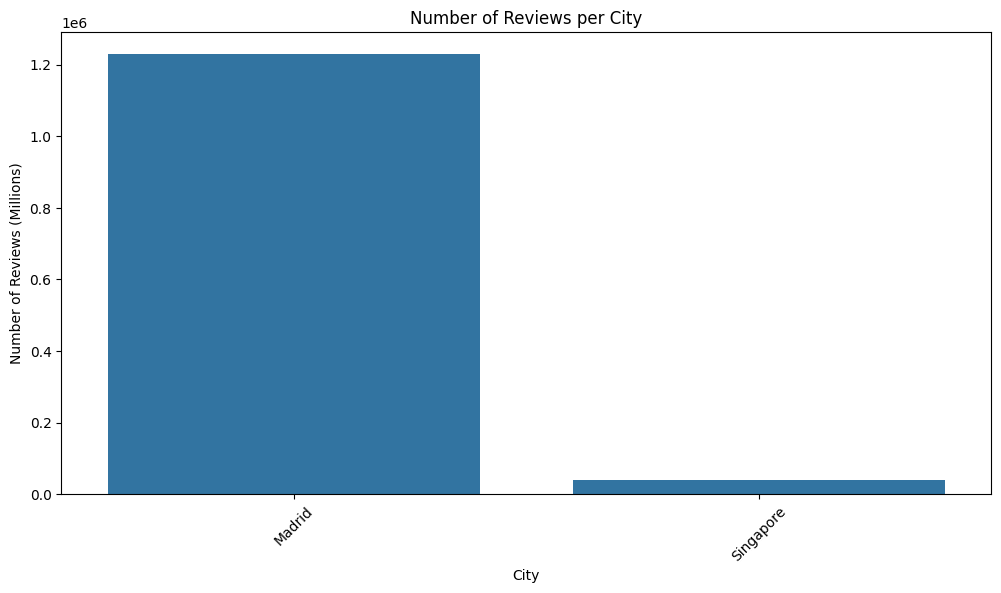

<Figure size 640x480 with 0 Axes>

In [6]:
#Show the distribution of number of reviews per city, make clear that it are millions of reviews
plt.figure(figsize=(12,6))
sns.countplot(data=reviews_combined, x='city', order=reviews_combined['city'].value_counts().index)
plt.xlabel('City')
plt.ylabel('Number of Reviews (Millions)')
plt.title('Number of Reviews per City')
plt.xticks(rotation=45)
plt.show()
plt.savefig('reviews_per_city_before_preprocessing.png')


Explanation of the Code

Language Filtering: We use TextBlob to detect the language of each review in the comments column, keeping only English reviews.

Text Preprocessing: We clean the comments by removing special characters and converting text to lowercase for consistency in the topic modeling step.

Topic Modeling: Using LDA with a CountVectorizer, we extract topics. You can adjust the number of topics (n_components) as needed.

Sentiment Analysis: For sentiment scoring, we calculate the polarity of each review using TextBlob, which provides a sentiment score between -1 (negative) and 1 (positive).

Aggregation: We group the reviews by listing_id and calculate the average sentiment score per listing.

This code will output a DataFrame, average_sentiment_per_listing, containing each listing's average sentiment score. This can be used for further analysis on how review sentiment correlates with listing performance.

In [7]:
reviews_combined.head()

listing_id        id        date  reviewer_id reviewer_name  \
0       21853  21051116  2014-10-10      8506071    Pedro Abel   
1       21853  21268157  2014-10-13     19062863          Olga   
2       21853  22527396  2014-11-09      6099461          Hugh   
3       21853  22684525  2014-11-11     23357657         Sendy   
4       21853  22871843  2014-11-16      4072731          Nati   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   comments  \
0                                                                                                                                                                                      Mi experiencia en casa de Adel fue buena, aunque al principio costo un poco ponernos de acuerdo para hacer la entrada al final conseguimos encontrar una hora conveniente para los dos. Aunque la casa y en especial la cocina estaba algo desordenada la habitación si estaba limpia y ordenada. El sitio es un barrio tranquilo y bien comunicado.   
1                                                                                                                                                                                                                                                                                                 Adel is a very warm person and thoughtful! He didn't have a hairdryer, but he bought one the next morning! Pretty cool, right? :) and the room has a nice view of the city, plus it's close to a park from where you can get great shots!   
2                                                                                                                                                                   Adel is an exceptionally welcoming host. I was ill during my stay and he was kind enough to accompany me to the doctor to translate for me! He really is an exceptionally pleasant person, very laid back and an interesting, knowledgable and articulate talker, even though he claims his English isn't that good! I couldn't recommend staying with him more highly.   
3  Adel fue muy amable, incluso el día de mi llegada fue por mi a la salida del metro y me ayudó con mi equipaje :). Durante mi estancia fue muy respetuoso y agradable, me explicó cómo funcionaban las cosas, me dió algunos tips para ahorrar. Es muy buen conversador y un a persona flexible en cuanto al check in y check out.\r<br/>\r<br/>La habitación es suficiente para una persona, estaba limpio y como soy muy friolenta Adel me ofreció cobijas extra. No tuve problemas con el internet. \r<br/>\r<br/>Gracias Adel.\r<br/>   
4                                                                                                                                                                                                                                                                                                             Abdel ha sido un magnífico anfitrión y la mejor forma que se me ocurre para describirlo es que me he sentido como en mi propia casa. Además, la casa es bonita, está limpia y es muy cómoda. Todo muy recomendable con ellos.   

     city  
0  Madrid  
1  Madrid  
2  Madrid  
3  Madrid  
4  Madrid

In [8]:
reviews_combined['listing_id'].nunique()

23088

In [9]:
reviews_combined['listing_id'].value_counts()

listing_id
16889632               1092
3908928                 986
51558636                970
29172802                965
3397465                 942
47945468                908
7783777                 904
9128910                 890
93100                   888
17735333                857
5170938                 839
9471684                 839
526513                  823
2452815                 797
16675905                796
3727205                 794
2862015                 792
838698                  790
28237489                777
21455170                766
709208                  766
11550407                760
6287069                 751
20200455                749
567301424368343959      748
1523675                 744
6287397                 743
18093383                728
576487                  726
2355344                 720
12064892                714
18702124                714
28891765                712
23674514                709
5756228                 709
6283743  

In [10]:
#add new word count column
reviews_combined['word_count'] = reviews_combined['comments'].apply(lambda x: len(str(x).split()))

In [11]:
# Step 1: Randomly sample 10,000 unique listing IDs
sampled_listing_ids = reviews_combined['listing_id'].drop_duplicates().sample(n=100, random_state=42)

# Step 2: Filter the DataFrame to include all reviews for the sampled listings
reviews_combined_sample = reviews_combined[reviews_combined['listing_id'].isin(sampled_listing_ids)]

# Step 3: Check the resulting shape
reviews_combined_sample.shape


(7475, 8)

In [12]:
reviews_combined.shape

(1267742, 8)

Step 1: Input review corpus and preprocess it.

In [13]:
# Download required NLTK data
nltk.download('punkt')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Step 1: Sample data and handle missing values
df = reviews_combined
df = reviews_combined.dropna(subset=['comments'])

# Step 2: Filter for English reviews
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

df['is_english'] = df['comments'].apply(is_english)
df = df[df['is_english']]
if len(df) == 0:
    raise ValueError("No English reviews found after filtering.")

# Step 3: Preprocess text (remove stopwords)
stopwords = set(ENGLISH_STOP_WORDS)

def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text.lower())  # Remove non-alphanumeric characters
    words = text.split()
    return ' '.join([word for word in words if word not in stopwords])

df['cleaned_comments'] = df['comments'].apply(preprocess_text)
df = df[df['cleaned_comments'].str.len() > 2]
if len(df) == 0:
    raise ValueError("No comments left after preprocessing.")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\PC\AppData\Local\Temp\ipykernel_15612\2021830876.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_english'] = df['comments'].apply(is_english)


In [14]:
df.head()

listing_id        id        date  reviewer_id reviewer_name  \
1       21853  21268157  2014-10-13     19062863          Olga   
2       21853  22527396  2014-11-09      6099461          Hugh   
6       21853  26150954  2015-02-05     22583630          Suzi   
7       21853  31678708  2015-05-08     32483419         Eunzi   
8       21853  32281555  2015-05-16     25217764       William   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          comments  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                        Adel is a very warm person and thoughtful! He didn't have a hairdryer, but he bought one the next morning! Pretty cool, right? :) and the room has a nice view of the city, plus it's close to a park from where you can get great shots!   
2                                                                                                                                                                                                                                                                                                                          Adel is an exceptionally welcoming host. I was ill during my stay and he was kind enough to accompany me to the doctor to translate for me! He really is an exceptionally pleasant person, very laid back and an interesting, knowledgable and articulate talker, even though he claims his English isn't that good! I couldn't recommend staying with him more highly.   
6  Adel is a very warm person. Actually, it was first time to come to Madrid and I couldn't speak Spanish at all also, that's why I felt little uneasy.\r<br/>However, Adel helped me everything; I asked Adel to talk with taxi driver and he did for me so, I could get home safely. \r<br/>I was lucky that I could meet a person who speaks English in Madrid(it is quite hard to find).\r<br/>In addition, this house makes me feel like it is my real home that I am living in my country and he and flatmate are like my real family.\r<br/>I love this house and people and even, Airbnb as well.\r<br/>I am sure I am going to stay this house if I come to Madrid again.\r<br/>Gracias:D   
7                                                                                                                                                                                                                                                                                                                  Adel and Nati(another flatmate) are very warm and kind. Even though it is not exactly in center, I was happy as I felt like it is real home and they are real family also, I love its neighborhood as well. People are all nice and welcoming in Calle de Carols Fuentes. The area is quite easy and close to get to the center so, I was also satisfied with its location.       
8                                                                                                                                                                                                                       

In [17]:
df.shape

(532224, 10)

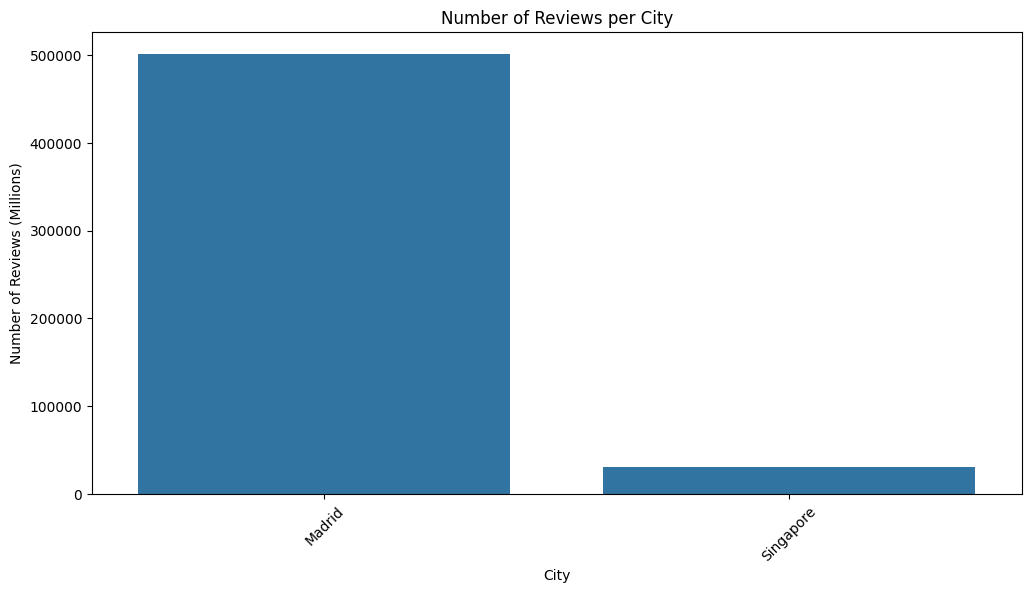

<Figure size 640x480 with 0 Axes>

In [18]:
#Show the distribution of number of reviews per city, make clear that it are millions of reviews
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='city', order=df['city'].value_counts().index)
plt.xlabel('City')
plt.ylabel('Number of Reviews (Millions)')
plt.title('Number of Reviews per City')
plt.xticks(rotation=45)
plt.show()
plt.savefig('reviews_per_city_after_preprocessing.png')


Step 2: Tokenize preprocessed corpus into words.

In [19]:
nltk.download('punkt')
nltk.download('punkt_tab')

# ------------------------ Step 1: Prepare the Data ------------------------

# Ensure 'cleaned_comments' is a non-empty string
df['cleaned_comments'] = df['cleaned_comments'].fillna('').astype(str)

# Subset the DataFrame to save memory
columns_to_keep = ['listing_id', 'cleaned_comments']
df_subset = df[columns_to_keep].copy()

# Ensure 'listing_id' is a string
df_subset['listing_id'] = df_subset['listing_id'].astype(str)

# Save the subset to a CSV for the next step
output_file = "prepared_reviews_oos.csv"
df_subset.to_csv(output_file, index=False)

print(f"Prepared DataFrame saved to {output_file}.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Prepared DataFrame saved to prepared_reviews_oos.csv.


In [20]:
# Load the prepared data
input_file = "prepared_reviews_oos.csv"
df_subset = pd.read_csv(input_file)

# Tokenization function
def tokenize_review(text):
    # Ensure the input is a string and preprocess it to remove accents
    return simple_preprocess(str(text), deacc=True)

# Define chunk size
chunk_size = 100000  # Adjust based on your system's memory capacity

# Initialize an empty list to store tokenized chunks
output_files = []  # Track all output chunk files

# Process the DataFrame in chunks
for start in tqdm(range(0, len(df_subset), chunk_size), desc="Processing Chunks"):
    end = start + chunk_size
    df_chunk = df_subset.iloc[start:end].copy()  # Use .copy() to avoid SettingWithCopyWarning
    
    # Tokenize the chunk
    df_chunk['tokens'] = df_chunk['cleaned_comments'].apply(tokenize_review)
    
    # Debug: Print a few tokenized rows for verification
    print("\nSample Tokens (After Tokenization):")
    print(df_chunk[['cleaned_comments', 'tokens']].head())
    
    # Save each chunk to a CSV to avoid memory issues
    output_chunk_file = f"tokenized_chunk_{start}_{end}.csv"
    df_chunk.to_csv(output_chunk_file, index=False)
    print(f"Tokenized chunk saved to {output_chunk_file}.")
    output_files.append(output_chunk_file)
    
    # Free memory
    del df_chunk
    gc.collect()

# Output summary of all saved chunks
print(f"\nAll chunks processed and saved: {output_files}")
# Combine all chunks into a single DataFrame
all_chunks = pd.concat([pd.read_csv(file) for file in output_files], ignore_index=True)

# Save the combined DataFrame
all_chunks.to_csv("tokenized_reviews_full_oos.csv", index=False)
print("All chunks combined and saved to tokenized_reviews_full_oos.csv.")



Processing Chunks:   0%|          | 0/6 [00:00<?, ?it/s]


Sample Tokens (After Tokenization):
                                                                                                                                                                                                                                                                                                                                                             cleaned_comments  \
0                                                                                                                                                                                                                                             adel warm person thoughtful didn t hairdryer bought morning pretty cool right room nice view city plus s close park great shots   
1                                                                                                                                                 adel exceptionally welcoming host ill stay kind accompany doctor translate real

Processing Chunks:  17%|█▋        | 1/6 [00:05<00:25,  5.19s/it]

Tokenized chunk saved to tokenized_chunk_0_100000.csv.

Sample Tokens (After Tokenization):
                                                                                                                                                                                                                                                                      cleaned_comments  \
100000                                         apartment decorated stylish br need apartment including kitchenware towels air felt floor apartment worn wooden stairs making uploading baggage bit dangerous br did expect water flood bathroom shower using bathroom shower room time   
100001  4 girls lovely stay javier s apartment details decoration beautiful stylish beautiful bathrooms kitchen equipped javier friendly answered quickly mention thing bedroom small bed actually person instead overall perfect stay good location near plaza mayor retiro park stay   
100002                                                        

Processing Chunks:  33%|███▎      | 2/6 [00:09<00:19,  4.89s/it]

Tokenized chunk saved to tokenized_chunk_100000_200000.csv.

Sample Tokens (After Tokenization):
                                                                                                                                                                                                                                                                                                                                         cleaned_comments  \
200000                                                                                                                                                                                  house great group 7 br 3 bathrooms real winner host communication great br house clean beds comfy br house greatlocation clean madrid busy short walk city centre   
200001                                                                                                                                                                                             checked 10

Processing Chunks:  50%|█████     | 3/6 [00:14<00:14,  4.71s/it]

Tokenized chunk saved to tokenized_chunk_200000_300000.csv.

Sample Tokens (After Tokenization):
                                                                                                                                                                                                                                                   cleaned_comments  \
300000                                perfectly clean tidy apartment need short stay s great location walking distance just gran vía mercado san miguel parque madrid palace mayor plaza great little bars tapas places mini supermarket shops street needing close   
300001                                                                                                                                                                                                    excellent location apartment nice perfect clean condition   
300002                                                                                                            

Processing Chunks:  67%|██████▋   | 4/6 [00:18<00:09,  4.52s/it]

Tokenized chunk saved to tokenized_chunk_300000_400000.csv.

Sample Tokens (After Tokenization):
                                                                                                              cleaned_comments  \
400000                                                      perfect location br super fast communication br highly recommended   
400001                                          place central visit attractions bars shopping venues foot good 4 guests 2 beds   
400002                                                                      great little place guest perfect location walkable   
400003                                                                             perfect location clean spacious appartement   
400004  great place great price comfy bed surprisingly quiet sleep cool location equipped needed helpful responsive easy check   

                                                                                                                          

Processing Chunks:  83%|████████▎ | 5/6 [00:22<00:04,  4.43s/it]

Tokenized chunk saved to tokenized_chunk_400000_500000.csv.

Sample Tokens (After Tokenization):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          cleaned_comments  \
500000                                                                                                                                                                                                                                                       great 1 bedroom apartment sweet neighborhood 15 minute walk atocha airport b

Processing Chunks: 100%|██████████| 6/6 [00:24<00:00,  4.05s/it]

Tokenized chunk saved to tokenized_chunk_500000_600000.csv.

All chunks processed and saved: ['tokenized_chunk_0_100000.csv', 'tokenized_chunk_100000_200000.csv', 'tokenized_chunk_200000_300000.csv', 'tokenized_chunk_300000_400000.csv', 'tokenized_chunk_400000_500000.csv', 'tokenized_chunk_500000_600000.csv']


All chunks combined and saved to tokenized_reviews_full_oos.csv.


In [21]:
# Path pattern for the chunk files
chunk_files_pattern = "tokenized_chunk_*.csv"

# Get a list of all chunk files
chunk_files = glob.glob(chunk_files_pattern)

# Read and combine all chunks
tokenized_chunks = [pd.read_csv(file) for file in chunk_files]
df_tokenized = pd.concat(tokenized_chunks, ignore_index=True)

# Save the combined tokenized DataFrame
output_file = "tokenized_reviews_combined_oos.csv"
df_tokenized.to_csv(output_file, index=False)

print(f"Combined tokenized DataFrame saved to {output_file}.")


Combined tokenized DataFrame saved to tokenized_reviews_combined_oos.csv.


In [28]:
df=pd.read_csv('tokenized_reviews_full_oos.csv')

In [30]:
df.head()

listing_id  \
0       21853   
1       21853   
2       21853   
3       21853   
4       21853   

                                                                                                                                                                                                                                                                                                                                                             cleaned_comments  \
0                                                                                                                                                                                                                                             adel warm person thoughtful didn t hairdryer bought morning pretty cool right room nice view city plus s close park great shots   
1                                                                                                                                                 adel exceptionally welcoming host ill stay kind accompany doctor translate really exceptionally pleasant person laid interesting knowledgable articulate talker claims english isn t good couldn t recommend staying highly   
2  adel warm person actually time come madrid couldn t speak spanish s felt little uneasy br adel helped asked adel talk taxi driver did home safely br lucky meet person speaks english madrid quite hard br addition house makes feel like real home living country flatmate like real family br love house people airbnb br sure going stay house come madrid br gracias d   
3                                                                                                                                                                              adel nati flatmate warm kind exactly center happy felt like real home real family love neighborhood people nice welcoming calle carols fuentes area quite easy close center satisfied location   
4                                                                                                                                                                                                                          pleasant journey apartment br make life easier roommates welcoming say nice br place located practical comfortable br josé fun br great place stay   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         tokens  
0                                                                                                                                                                                                                                                                                                                                                                      ['adel', 'warm', 'person', 'thoughtful', 'didn', 'hairdryer', 'bought', 'morning', 'pretty', 'cool', 'right', 'room', 'nice', 'view', 'city', 'plus', 'close', 'park', 'great', 'shots']  
1                                                                                                                                                                                                                                                     ['adel', 'exceptionally', 'welcoming', 'host', 'ill', 'stay', 'kind', 'accompany', 'doctor', 'translate', 'really', 'exceptionally', 'pleasant', 'person', 'laid', 'interesting', 'knowledgable', 'articulate', 'talker', 'claims', 'english', 'isn', 'good', 'couldn', 'recommend', 'staying', 'highly']  
2  ['adel', 'warm', 'person', 'actually', 'time

In [31]:
# Path to the combined tokenized DataFrame
input_file = "tokenized_reviews_full_oos.csv"
output_file = "tokenized_reviews_cleaned_oos.csv"

# Process the file in chunks
chunksize = 10000  # Adjust this based on available memory
with pd.read_csv(input_file, chunksize=chunksize) as reader:
    for i, chunk in enumerate(tqdm(reader, desc="Processing Chunks")):
        # Convert the 'tokens' column from string to list
        chunk['tokens'] = chunk['tokens'].apply(ast.literal_eval)

        # Save the processed chunk back to a new file
        mode = 'w' if i == 0 else 'a'  # Write header only for the first chunk
        chunk.to_csv(output_file, mode=mode, index=False, header=(i == 0))

print(f"Processed file saved to {output_file}.")



Processing Chunks: 54it [00:36,  1.48it/s]

Processed file saved to tokenized_reviews_cleaned_oos.csv.


Step 3: Remove outliers from tokenized words

In [32]:
from collections import Counter

# Initialize a Counter and total review count
word_in_reviews_count = Counter()
total_reviews = 0

# Process the cleaned file in chunks
with pd.read_csv(output_file, chunksize=chunksize) as reader:
    for chunk in tqdm(reader, desc="Counting Words"):
        # Ensure 'tokens' column is a list
        chunk['tokens'] = chunk['tokens'].apply(ast.literal_eval)

        # Update total reviews
        total_reviews += len(chunk)

        # Count unique words in each review
        for tokens in chunk['tokens']:
            unique_words = set(tokens)  # Count each word only once per review
            word_in_reviews_count.update(unique_words)

# Determine frequent words based on the threshold
threshold = 0.1  # 10%
frequent_words = [
    word for word, count in word_in_reviews_count.items() if count / total_reviews > threshold
]

# Output results
print(f"\nTotal reviews processed: {total_reviews}")
print(f"Total unique words considered: {len(word_in_reviews_count)}")
print(f"Words removed for being in more than {threshold * 100}% of the reviews: {len(frequent_words)}")
print(f"Frequent words: {frequent_words}")




Counting Words: 54it [00:20,  2.65it/s]


Total reviews processed: 532224
Total unique words considered: 72659
Words removed for being in more than 10.0% of the reviews: 22
Frequent words: ['close', 'nice', 'great', 'really', 'recommend', 'good', 'stay', 'host', 'madrid', 'br', 'easy', 'location', 'located', 'place', 'apartment', 'comfortable', 'helpful', 'definitely', 'metro', 'clean', 'perfect', 'restaurants']


In [33]:
print(f"List of frequent words : {frequent_words}")

List of frequent words : ['close', 'nice', 'great', 'really', 'recommend', 'good', 'stay', 'host', 'madrid', 'br', 'easy', 'location', 'located', 'place', 'apartment', 'comfortable', 'helpful', 'definitely', 'metro', 'clean', 'perfect', 'restaurants']


In [34]:
#Save frequent words as csv
frequent_words_df = pd.DataFrame(frequent_words)
frequent_words_df.to_csv('frequent_words_oos.csv', index=False)

In [35]:
#import csv
frequent_words_df = pd.read_csv('frequent_words_oos.csv')

Step 4: Create a Bag of Words (BOW) representation with Gensim

In [36]:
frequent_words_df

0
0         close
1          nice
2         great
3        really
4     recommend
5          good
6          stay
7          host
8        madrid
9            br
10         easy
11     location
12      located
13        place
14    apartment
15  comfortable
16      helpful
17   definitely
18        metro
19        clean
20      perfect
21  restaurants

In [38]:
# Input file paths
input_file = "tokenized_reviews_cleaned_oos.csv"  # Cleaned file from previous step
bow_output_file = "corpus_bow_oos.mm"  # Output file for BOW corpus
dictionary_output_file = "dictionary_oos.dict"  # Output file for Gensim dictionary

# Step 1: Load frequent words into a set for fast filtering
frequent_words_set = set(frequent_words_df['0'])

# Step 2: Initialize Gensim dictionary and corpus
dictionary = Dictionary()

# Process the tokenized file in chunks to create BOW
chunk_size = 10000  # Adjust for your system's memory
corpus_bow = []

print("Processing the file to create Bag of Words (BOW) representation...")
with pd.read_csv(input_file, chunksize=chunk_size) as reader:
    for chunk in tqdm(reader, desc="Filtering Tokens and Creating BOW"):
        # Convert stringified tokens to lists
        chunk['tokens'] = chunk['tokens'].apply(ast.literal_eval)

        # Filter tokens to exclude frequent words
        chunk['filtered_tokens'] = chunk['tokens'].apply(
            lambda tokens: [word for word in tokens if word not in frequent_words_set]
        )

        # Add filtered tokens to the dictionary
        dictionary.add_documents(chunk['filtered_tokens'])

        # Create BOW representation for the current chunk
        chunk_bow = [dictionary.doc2bow(tokens) for tokens in chunk['filtered_tokens']]
        corpus_bow.extend(chunk_bow)

        # Free memory for the chunk
        del chunk, chunk_bow

# Save the dictionary and BOW corpus
dictionary.save(dictionary_output_file)
print(f"Dictionary saved to {dictionary_output_file} with {len(dictionary)} unique tokens.")

MmCorpus.serialize(bow_output_file, corpus_bow)
print(f"BOW corpus saved to {bow_output_file} for {len(corpus_bow)} documents.")




Processing the file to create Bag of Words (BOW) representation...


Filtering Tokens and Creating BOW: 54it [00:32,  1.67it/s]


Dictionary saved to dictionary_oos.dict with 72637 unique tokens.
BOW corpus saved to corpus_bow_oos.mm for 532224 documents.


In [39]:
# Load the dictionary
dictionary = Dictionary.load('dictionary_oos.dict')
print(f"Loaded dictionary with {len(dictionary)} unique tokens.")

# Inspect the dictionary
print("Sample token-to-ID mappings:")
for token, token_id in list(dictionary.token2id.items())[:10]:
    print(f"  Token: {token}, ID: {token_id}")

# Load the corpus
corpus_bow = MmCorpus('corpus_bow_oos.mm')
print(f"Loaded corpus with {len(corpus_bow)} documents.")

# Inspect the corpus
print("Sample document from the corpus:")
if len(corpus_bow) > 0:
    sample_doc = corpus_bow[0]
    print(f"  BOW: {sample_doc}")
    print("  Decoded tokens:")
    print([dictionary[token_id] for token_id, freq in sample_doc])

# Plot token frequency distribution
token_frequencies = [freq for _, freq in dictionary.dfs.items()]
plt.hist(token_frequencies, bins=50, log=True)
plt.xlabel("Document Frequency")
plt.ylabel("Count")
plt.title("Token Frequency Distribution")
plt.show()


Loaded dictionary with 72637 unique tokens.
Sample token-to-ID mappings:
  Token: adel, ID: 0
  Token: bought, ID: 1
  Token: city, ID: 2
  Token: cool, ID: 3
  Token: didn, ID: 4
  Token: hairdryer, ID: 5
  Token: morning, ID: 6
  Token: park, ID: 7
  Token: person, ID: 8
  Token: plus, ID: 9
Loaded corpus with 532224 documents.
Sample document from the corpus:
  BOW: [(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0), (16, 1.0)]
  Decoded tokens:
['adel', 'bought', 'city', 'cool', 'didn', 'hairdryer', 'morning', 'park', 'person', 'plus', 'pretty', 'right', 'room', 'shots', 'thoughtful', 'view', 'warm']


In [40]:
# Print the first 5 documents in the corpus
print("First 5 documents in the corpus (BOW format):")
print(corpus_bow[:5])


First 5 documents in the corpus (BOW format):


Step 6: Define Simulated Annealing to Optimize LDA Parameters

Step 6: Train LDA model with optimized parameters and extract topic-word probabilities

In [41]:
print("Training LDA model with optimized parameters...")
lda_model = LdaModel(
    corpus=corpus_bow,
    id2word=dictionary,
    num_topics=4,
    random_state=42
)

# Extract topic-word probability distribution
topic_word_distributions = lda_model.get_topics()

Training LDA model with optimized parameters...


In [42]:
topic_word_distributions.shape

(4, 72637)

In [43]:
#Save lda model
lda_model.save('lda_model_oos')


In [44]:
#Load lda model
lda_model = LdaModel.load('lda_model_oos')

In [45]:
#print topics of lda model
print(lda_model.print_topics())

[(0, '0.025*"room" + 0.009*"small" + 0.009*"bed" + 0.008*"bathroom" + 0.008*"night" + 0.008*"check" + 0.007*"bit" + 0.007*"overall" + 0.006*"kitchen" + 0.006*"just"'), (1, '0.052*"mrt" + 0.040*"station" + 0.027*"walk" + 0.026*"bus" + 0.025*"near" + 0.024*"singapore" + 0.016*"food" + 0.016*"convenient" + 0.014*"chinatown" + 0.013*"away"'), (2, '0.026*"city" + 0.026*"walking" + 0.023*"distance" + 0.017*"area" + 0.016*"quiet" + 0.014*"center" + 0.013*"walk" + 0.013*"lots" + 0.012*"right" + 0.010*"places"'), (3, '0.025*"friendly" + 0.016*"thank" + 0.015*"check" + 0.015*"super" + 0.014*"highly" + 0.014*"time" + 0.014*"responsive" + 0.013*"room" + 0.013*"home" + 0.013*"amazing"')]


In [46]:
df['listing_id'].value_counts()

listing_id
47945468               719
3908928                642
3397465                629
5170938                581
709208                 539
2650925                538
2652829                533
2452815                513
3727205                507
261878                 502
3584830                498
48033351               452
7110133                451
531677                 442
9385154                435
11550407               434
1523675                434
21389483               424
93100                  419
608742                 414
6961269                400
16213864               398
2355344                398
7214366                396
48019222               393
16889632               393
926653                 392
18702124               391
5756228                390
925250                 385
6542642                384
526513                 383
1320674                376
9128910                375
10676283               375
4687759                374
1680271          

In [47]:
# Step 2: Extract topic-word distributions
topic_word_distributions = lda_model.get_topics()

# Step 3: Display top words per topic
print("\nTop Words per Topic:")
for topic_idx, topic_distribution in enumerate(topic_word_distributions):
    top_words = [dictionary[i] for i in topic_distribution.argsort()[-15:][::-1]]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

# Step 4: Calculate topic probabilities and assign dominant topics
topic_probabilities = []
dominant_topics = []

for doc in corpus_bow:  # Iterate over the first 5000 reviews
    topic_distribution = lda_model.get_document_topics(doc, minimum_probability=0)
    probs = [prob for _, prob in topic_distribution]
    topic_probabilities.append(probs)
    dominant_topics.append(np.argmax(probs))

# Step 5: Create a DataFrame with topic probabilities and dominant topics
df = pd.DataFrame({
    'listing_id': range(len(dominant_topics)),
    'dominant_topic': dominant_topics
})

for topic_idx in range(lda_model.num_topics):
    df[f"topic_{topic_idx}_probability"] = [probs[topic_idx] for probs in topic_probabilities]

# Display the DataFrame
print(df.tail())

# Save the DataFrame to a CSV file
output_file = "topic_probabilities_oos.csv"
df.to_csv(output_file, index=False)
print(f"Topic probabilities saved to {output_file}.")


Top Words per Topic:
Topic #1: room, small, bed, bathroom, night, check, bit, overall, kitchen, just, like, shower, didn, little, day
Topic #2: mrt, station, walk, bus, near, singapore, food, convenient, chinatown, away, minutes, airport, nearby, stop, train
Topic #3: city, walking, distance, area, quiet, center, walk, lots, right, places, public, attractions, bars, just, transport
Topic #4: friendly, thank, check, super, highly, time, responsive, room, home, amazing, thanks, singapore, experience, staying, like
        listing_id  dominant_topic  topic_0_probability  topic_1_probability  \
532219      532219               0             0.980654             0.006480   
532220      532220               0             0.973994             0.019511   
532221      532221               3             0.369112             0.078887   
532222      532222               3             0.036128             0.035768   
532223      532223               3             0.027590             0.025497   



In [48]:
df_topics=pd.read_csv('topic_probabilities_oos.csv')
df_topics=df_topics.drop(columns=['listing_id'])

In [50]:
df_reviews=pd.read_csv('reviews_combined_cleaned_out_of_sample.csv')

In [51]:
#Combine the two dataframes
df=pd.concat([df_reviews, df_topics], axis=1)


Step 8: Rank topmost aspects and calculate average topic probability per listing

Textblob sentiment

In [54]:
# Step 1: Define a function to calculate sentiment
def textblob_sentiment(text):
    """
    Returns the polarity (ranging from -1.0 to 1.0) of a given text.
    """
    blob = TextBlob(str(text))  # Convert text to string
    return blob.sentiment.polarity

df['sentiment_score'] = df['comments'].apply(textblob_sentiment)

# Step 3: Assign the sentiment score to the dominant topic's sentiment column
for i in range(4):
    df[f'topic_{i}_dominant_sentiment'] = df.apply(
        lambda row: row['sentiment_score'] if row['dominant_topic'] == i else 0,
        axis=1
    )

# Step 4: Calculate the average sentiment for each topic per listing
average_sentiment_per_listing = df.groupby('listing_id')[
    [f'topic_{i}_dominant_sentiment' for i in range(4)]
].mean().reset_index()

# Rename columns for clarity
average_sentiment_per_listing.rename(
    columns={f'topic_{i}_dominant_sentiment': f'topic_{i}_average_sentiment' for i in range(4)},
    inplace=True
)

# Step 5: Display the average sentiment per listing for each topic
print("\nAverage Sentiment per Listing for Each Topic:")
print(average_sentiment_per_listing)










Average Sentiment per Listing for Each Topic:
                listing_id  topic_0_average_sentiment  \
0                    21853               7.445612e-02   
1                    24805               9.087582e-02   
2                    30320               1.124941e-01   
3                    30959               0.000000e+00   
4                    40718               1.051230e-01   
5                    40916               9.702332e-02   
6                    62423               3.749617e-02   
7                    70059               1.104548e-01   
8                    70073               8.307496e-02   
9                    70310               8.339498e-02   
10                   71609               9.197917e-02   
11                   71896               8.787810e-02   
12                   71903               1.153375e-01   
13                   72150               9.227437e-02   
14                   82481               8.480954e-02   
15                   84719               

In [55]:
#Step 13: Add the average word count per listing of original reviews_combined to the dataframe
average_word_count_per_listing = df.groupby('listing_id').agg({
    'word_count': 'mean'
}).reset_index()
average_sentiment_per_listing= average_sentiment_per_listing.merge(average_word_count_per_listing, on='listing_id')
average_sentiment_per_listing.rename(columns={'word_count':'average_word_count'}, inplace=True)

# Display the result
print("\nAverage Sentiment Score per Topic for Each Listing:")
print(average_sentiment_per_listing.head())


Average Sentiment Score per Topic for Each Listing:
   listing_id  topic_0_average_sentiment  topic_1_average_sentiment  \
0       21853                   0.074456                   0.022696   
1       24805                   0.090876                   0.018963   
2       30320                   0.112494                   0.012786   
3       30959                   0.000000                   0.000000   
4       40718                   0.105123                   0.018968   

   topic_2_average_sentiment  topic_3_average_sentiment  average_word_count  
0                   0.037672                   0.225887           58.823529  
1                   0.206129                   0.137630           43.866667  
2                   0.101922                   0.147225           64.684211  
3                   0.072500                   0.268229           33.500000  
4                   0.114130                   0.163913           59.483146  


In [56]:
average_sentiment_per_listing.shape


(19764, 6)

In [57]:
#Save as csv
average_sentiment_per_listing.to_csv('average_sentiment_per_listing_textblob_oos.csv', index=False)

In [58]:
#count duplicates
average_sentiment_per_listing.duplicated().sum()

0

In [59]:
average_sentiment_per_listing.head(20)

listing_id  topic_0_average_sentiment  topic_1_average_sentiment  \
0        21853                   0.074456                   0.022696   
1        24805                   0.090876                   0.018963   
2        30320                   0.112494                   0.012786   
3        30959                   0.000000                   0.000000   
4        40718                   0.105123                   0.018968   
5        40916                   0.097023                   0.011510   
6        62423                   0.037496                   0.016429   
7        70059                   0.110455                   0.014159   
8        70073                   0.083075                   0.000000   
9        70310                   0.083395                   0.000000   
10       71609                   0.091979                   0.071269   
11       71896                   0.087878                   0.036030   
12       71903                   0.115337                   0.086175   
13       72150                   0.092274                   0.004762   
14       82481                   0.084810                   0.047321   
15       84719                   0.081994                   0.007849   
16       86042                   0.065342                   0.016487   
17       93100                   0.099053                   0.016688   
18      100411                   0.708333                   0.000000   
19      102194                   0.115861                   0.000000   

    topic_2_average_sentiment  topic_3_average_sentiment  average_word_count  
0                    0.037672                   0.225887           58.823529  
1                    0.206129                   0.137630           43.866667  
2                    0.101922                   0.147225           64.684211  
3                    0.072500                   0.268229           33.500000  
4                    0.114130                   0.163913           59.483146  
5                    0.124029                   0.093104           48.875000  
6                    0.069834                   0.335285           42.551020  
7                    0.064903                   0.162154           85.035714  
8                    0.115131                   0.168569           63.814815  
9                    0.131736                   0.201030           58.312500  
10                   0.073214                   0.166070           33.125000  
11                   0.033333                   0.141506           70.000000  
12                   0.006239                   0.151239           48.692308  
13                   0.168597                   0.154024           45.523810  
14                   0.092741                   0.169324           83.701493  
15                   0.093854                   0.198046           68.453333  
16                   0.157167                   0.200669           52.714286  
17                   0.068885                   0.202978           60.930788  
18                   0.000000                   0.000000           13.000000  
19                   0.075336                   0.243299           87.681818

Vader Sentiment

In [60]:
# Download the VADER lexicon (required for nltk SentimentIntensityAnalyzer)
download('vader_lexicon')

# Step 1: Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Step 2: Define a function to calculate sentiment using VADER
def vader_sentiment(text):
    """
    Returns the compound sentiment score (ranging from -1.0 to 1.0) of a given text using VADER.
    """
    sentiment = sia.polarity_scores(str(text))  # Convert text to string and calculate sentiment
    return sentiment['compound']  # Use the compound score

# Step 3: Calculate sentiment scores
df['sentiment_score'] = df['comments'].apply(vader_sentiment)

# Step 4: Assign the sentiment score to the dominant topic's sentiment column
for i in range(4):  # Assuming topics are topic_0 to topic_3
    df[f'topic_{i}_dominant_sentiment'] = df.apply(
        lambda row: row['sentiment_score'] if row['dominant_topic'] == i else 0,
        axis=1
    )

# Step 5: Calculate the average sentiment for each topic per listing
average_sentiment_per_listing_vader = df.groupby('listing_id')[
    [f'topic_{i}_dominant_sentiment' for i in range(4)]
].mean().reset_index()

# Rename columns for clarity
average_sentiment_per_listing_vader.rename(
    columns={f'topic_{i}_dominant_sentiment': f'topic_{i}_average_sentiment' for i in range(4)},
    inplace=True
)

# Step 6: Display the average sentiment per listing for each topic
print("\nAverage Sentiment per Listing for Each Topic:")
print(average_sentiment_per_listing_vader)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Average Sentiment per Listing for Each Topic:
                listing_id  topic_0_average_sentiment  \
0                    21853                   0.219500   
1                    24805                   0.166620   
2                    30320                   0.342388   
3                    30959                   0.000000   
4                    40718                   0.270542   
5                    40916                   0.218121   
6                    62423                   0.077762   
7                    70059                   0.398696   
8                    70073                   0.119781   
9                    70310                   0.346662   
10                   71609                   0.160269   
11                   71896                   0.314038   
12                   71903                   0.196615   
13                   72150                   0.199045   
14                   82481                   0.214469   
15                   84719               

In [61]:
#Step 13: Add the average word count per listing of original reviews_combined to the dataframe
average_word_count_per_listing = df.groupby('listing_id').agg({
    'word_count': 'mean'
}).reset_index()
average_sentiment_per_listing_vader= average_sentiment_per_listing_vader.merge(average_word_count_per_listing, on='listing_id')
average_sentiment_per_listing_vader.rename(columns={'word_count':'average_word_count'}, inplace=True)

# Display the result
print("\nAverage Sentiment Score per Topic for Each Listing:")
print(average_sentiment_per_listing_vader.head())


Average Sentiment Score per Topic for Each Listing:
   listing_id  topic_0_average_sentiment  topic_1_average_sentiment  \
0       21853                   0.219500                   0.054118   
1       24805                   0.166620                   0.048427   
2       30320                   0.342388                   0.027850   
3       30959                   0.000000                   0.000000   
4       40718                   0.270542                   0.038545   

   topic_2_average_sentiment  topic_3_average_sentiment  average_word_count  
0                   0.097053                   0.542571           58.823529  
1                   0.412827                   0.181893           43.866667  
2                   0.224611                   0.252387           64.684211  
3                   0.118850                   0.470500           33.500000  
4                   0.272237                   0.303761           59.483146  


In [62]:
#Save as csv
average_sentiment_per_listing_vader.to_csv('average_sentiment_per_listing_vader_oos.csv', index=False)